# SVM primer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_blobs

from IPython.display import display, Math, Latex

Let's make some randome samples that belong to either of two possible classes (y=0, or y=1), and plot that, to see what is the challenge that we have with the SVM

In [2]:
X, y = make_blobs(n_samples=50, n_features=2, centers=2,
                  cluster_std=1.8, random_state=3)

Here, we build a method that will plot the points used along this exercise, together with the decision boundary, the margins and the support vectors... but do not hurry with all those extra features, as it will be explained later on. This method is simply to plot results. Come back to it if you're curious on how I made it. The relevant parts are not in this method.

In [3]:
def plot(X, y, model=None, ax=None, margin=False, support_vectors=False):
    X0 = np.vstack([X[i, :] for i, v in enumerate(y) if v == 0])
    X1 = np.vstack([X[i, :] for i, v in enumerate(y) if v == 1])
    if ax is None:
        ax = plt.gca()
    ax.set_ylim(-4, 8)
    ax.scatter(X0[:, 0], X0[:, 1], marker='+', s=190, c='green')
    ax.scatter(X1[:, 0], X1[:, 1], marker='o', s=190,
                facecolors='none', edgecolors='blue')
    
    # if model has not been trained yet, this method ends here.
    if model is None:
        return

    # Draw the decision boundary
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-7, 2)
    yy = a * xx - (model.intercept_[0]) / w[1]
    ax.plot(xx, yy, 'k-')
    if margin:
        # Compute the margin.
        mu = 1 / np.sqrt(np.sum(w ** 2))
        yy_u = yy + np.sqrt(1+a**2) * mu
        yy_d = yy - np.sqrt(1+a**2) * mu
        ax.plot(xx, yy_u, c='k', linestyle='--')
        ax.plot(xx, yy_d, c='k', linestyle='--')
    if support_vectors:
        sv = model.support_vectors_
        ax.scatter(sv[:,0], sv[:,1], s=200, marker="s",
                   facecolors="none", edgecolors="orange")

Plot the points to see how challenging the problem is. If you want to make the problem harder, increase the value of `cluster_std` and you will see closer and closer points from both classes.

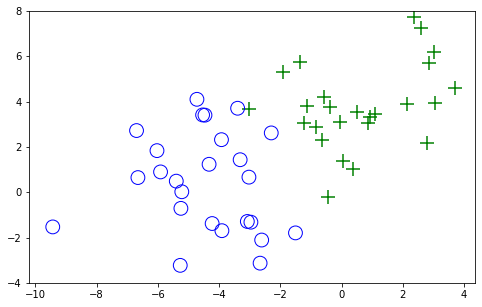

In [4]:
plt.figure(figsize=(8, 5))
plot(X, y)

## Fitting an SVM to our data

Fitting an SVM is as easy as with the other methods. We're following the typical sklearn steps for any model. We're also plotting the decision bounday in the plot below.

[In this page](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html) you can find a first way of extracting the linear decision boundary that SVM finds. There's another method that computes the decision boundary as a `contour` but it is less intuitive than this one. 

Remember that when computing $ \theta^{T} x $ we are computing a very similar expresion to the one used in linear regression with $ \hat{y} = \beta_{0} + \beta_1 x = \beta^{T} x $, but using the term $\theta$ instead of $\beta$.

You can extract `coef_` and `intercept_` parameters out of the model object (`model`), and use then to build a simple equation for the decision boundary as follows:

$$
\begin{align}
w & = \texttt{model.coef}\_ \\
I & = \texttt{model.intercept}\_ \\
\\
a & = -w_0 / w_1 \\
b & = I_0 / w_1 \\
\\
y &= a x - b
\end{align}
$$

You can see the code that plots this chart below in the method `plot()` defined on the first part of this notebook. And the following picture also illustrates what is the relationship between the coefficients ($ w \equiv a$ in our equations above)

<img src="https://i.stack.imgur.com/qt3CZ.png" width="40%">

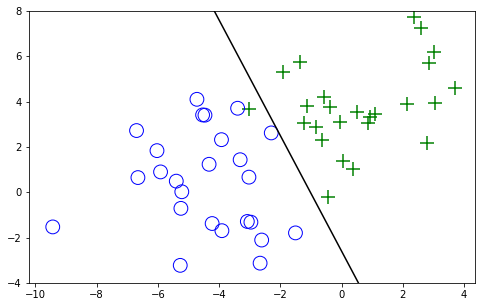

In [5]:
model = SVC(kernel='linear', C=1E10).fit(X, y)

plt.figure(figsize=(8, 5))
plot(X, y, model)

## Effect of $ C $

To illustrate the effect of C, we're going to fit three different models with three different values of C, and plot the decision boundary for each of them. We should observe how, as $C$ increases, SVM becomes more extrict with the decision boundary and tries to achieve the perfect separation between classes (at the expense of narrowing the margin between them), instead of allowing some outliers (lower values of $C$), and making the marging a bit wider.

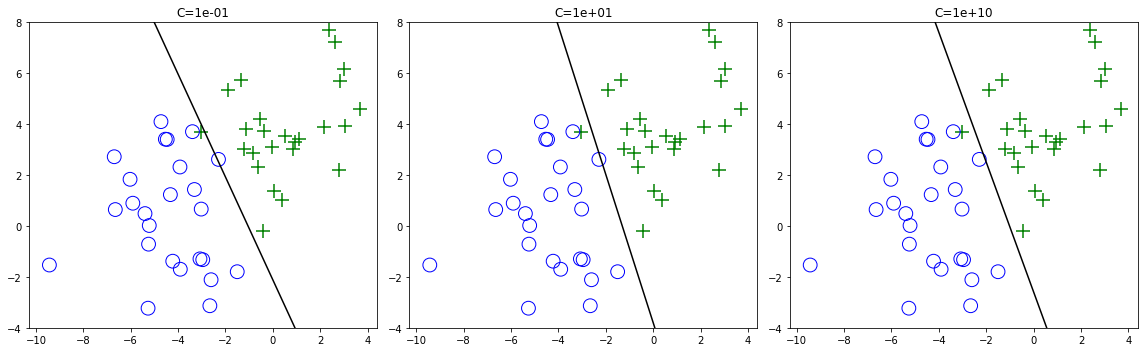

In [6]:
# Define the values that we want to explore for "C"
C_values = [0.1, 10, 1e10]

fig, ax = plt.subplots(nrows=1, ncols=len(C_values))
fig.set_size_inches(16,5)
for i, C_value in enumerate(C_values):
    model = SVC(kernel='linear', C=C_value).fit(X, y)
    plot(X, y, model, ax[i])
    ax[i].set_title(f"C={C_value:.0e}")
plt.tight_layout()
plt.show()

It is interesting how we can get three slightly different decision boundaries for the proposed values of $C$, with different results.

## What about the margin?

Tipically, the margins are computed from the coefficients obtained during the optimization problem that drives SVM, that we reviewed in class. The optimization process has the goal of minimizing the cost (_hinge loss_) function. So, we can expect that in order to know what is the _large margin_ obtained from the fittin process, we must also use the coefficients. The formula for the margin ($\mu$) is:

$$ \mu = \frac{1}{\sum_{i}^{p}{\theta^2}} $$

and to place that margin over and below the decision boundary, we use this other expression:

$$ 
y^{upper} = y + \mu \sqrt{1+a^2} \\
y^{lower} = y - \mu \sqrt{1+a^2}
$$

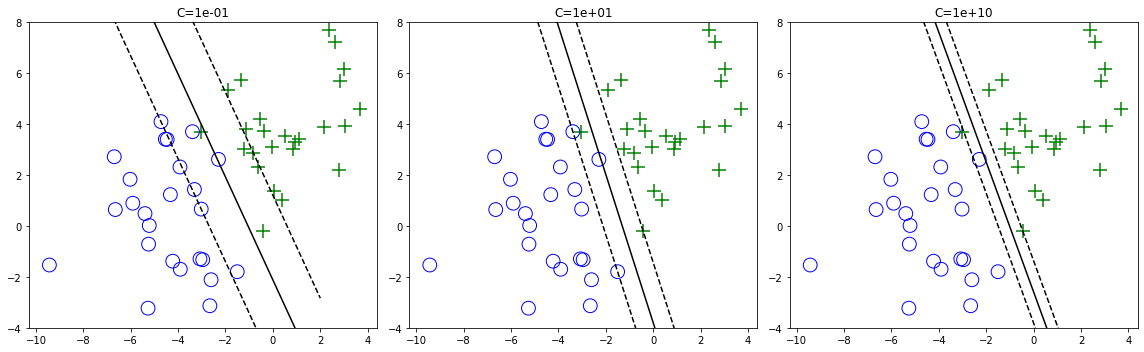

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=len(C_values))
fig.set_size_inches(16,5)
for i, C_value in enumerate(C_values):
    model = SVC(kernel='linear', C=C_value).fit(X, y)
    plot(X, y, model, ax[i], margin=True)
    ax[i].set_title(f"C={C_value:.0e}")
plt.tight_layout()
plt.show()

### Performance with different values of $C$

What is the performance of our decision on the value of $C$? Let's check it out. We simply need to score the predictions made on the training set (though this is not entirely correct, since we should have a test set, and perform cross validation, etc., but at this moment we're simply interested on how good are our different fits).

In [8]:
for i, C_value in enumerate(C_values):
    model = SVC(kernel='linear', C=C_value).fit(X, y)
    mu = 1 / np.sqrt(np.sum(model.coef_ ** 2))
    accuracy = model.score(X, y)
    print(f"SVM (margin={mu:.2f})(C={C_value})'s accuracy: {accuracy:.4f}")

SVM (margin=1.48)(C=0.1)'s accuracy: 0.9600
SVM (margin=0.77)(C=10)'s accuracy: 0.9800
SVM (margin=0.45)(C=10000000000.0)'s accuracy: 0.9800


We can observe than the best performance (in training) is obtained using $C = 10$. The margin is still acceptable, and the number of missclassifications is only one sample. Lower values ($C = 0.1$) produce better margins (very large, actually) which guarantees that our model will have higher bias, at the expense of incurring in some classification mistakes: this model is able to generalize better. And finally, higher values ($C =  1e10$) only contribute to reduce the margin and produce no improvement in our problem (which is not linearly separable, so increasing $C$ even further will not produce better results).

## Where are the "support vectors"?

Support vectors are those samples that "win" the optimization competition that takes place when the model is fit. Or, in other words, are those samples that are used to anchor the margin.

In sklearn we can access them directly from the model and easily plot them. Let's see how they look, squaring them in an orange box, in the plot below.

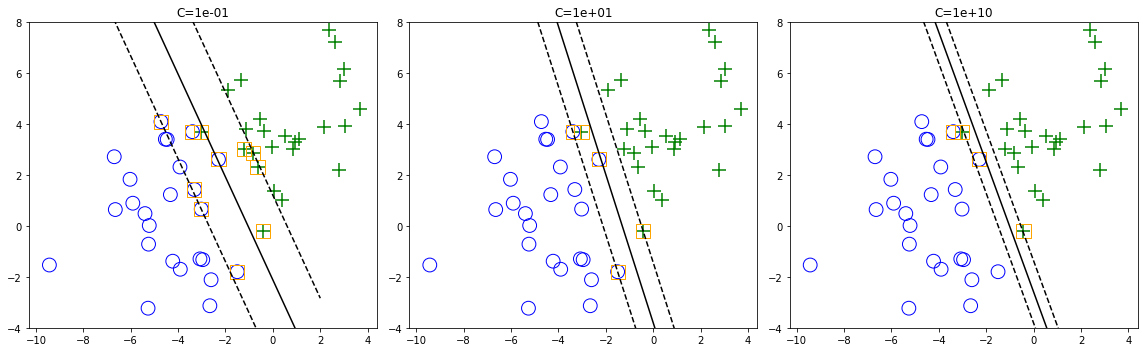

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=len(C_values))
fig.set_size_inches(16,5)
for i, C_value in enumerate(C_values):
    model = SVC(kernel='linear', C=C_value).fit(X, y)
    plot(X, y, model, ax[i], margin=True, support_vectors=True)
    ax[i].set_title(f"C={C_value:.0e}")
plt.tight_layout()
plt.show()

The number of support vectors heavily depends on how flexible we want our model to be. The more flexible, the more support vectors, and the wider the margin, tipically. With lower support vectors, what we have is a more rigid separation between classes. Your job as DS is to find the proper trade off between flexibility and performance.

More than that, support vectors can help you to gain interpretability on the results.